In [1]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
import time

# Set up logging
logging.getLogger('pyvisa').setLevel(logging.WARNING)

# Create a resource manager with logging
rm = pyvisa.ResourceManager()

# List available resources
print("Available Resources:")
resources = rm.list_resources()
for resource in resources:
    print(resource)

# Connect to the instrument (replace 'YOUR_INSTRUMENT_ADDRESS' with the actual address)
instrument_address = 'USB0::0x1AB1::0x04CE::DS1ZA232605402::INSTR'
instrument = rm.open_resource(instrument_address)

# Send the SCPI command to get the ID
idn = instrument.query("*IDN?")

# Print the identification string
print(f"Instrument ID: {idn}")

Available Resources:
USB0::0x1AB1::0x04CE::DS1ZA232605402::INSTR
USB0::0x1AB1::0x0642::DG1ZA232402828::INSTR
ASRL3::INSTR
Instrument ID: RIGOL TECHNOLOGIES,DS1054Z,DS1ZA232605402,00.04.05.SP1



In [3]:
instrument.write(":CH1:SCALe 20mV")  # Select Channel 1
measurement_data = instrument.query(":CH1:SCALe?")  # Change command as needed
time.sleep(1)

# Print the measurement data
print("Data:", measurement_data)

VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

Header Info: ä  {"TIMEBASE":{"SCALE":"1.0ms","HOFFSET":0},"SAMPLE":{"FULLSCREEN":1520,"SLOWMOVE":-1,"DATALEN":1520,"SAMPLERATE":"(1MS/s)","TYPE":"SAMPle","DEPMEM":"20K"},"CHANNEL":[{"NAME":"CH1","DISPLAY":"ON","Current_Rate":10000.000000,"Current_Ratio":0.031250,"Measure_Current_Switch":"OFF","COUPLING":"DC","PROBE":"1X","SCALE":"20.0mV","OFFSET":0,"FREQUENCE":1000.00000,"INVERSE":"OFF"},{"NAME":"CH2","DISPLAY":"OFF","Current_Rate":10000.000000,"Current_Ratio":0.007813,"Measure_Current_Switch":"OFF","COUPLING":"DC","PROBE":"1X","SCALE":"5.00mV","OFFSET":0,"FREQUENCE":1000.00000,"INVERSE":"OFF"},{"NAME":"CH3","DISPLAY":"OFF","Current_Rate":10000.000000,"Current_Ratio":0.007813,"Measure_Current_Switch":"OFF","COUPLING":"DC","PROBE":"1X","SCALE":"5.00mV","OFFSET":-65,"FREQUENCE":1000.00000,"INVERSE":"OFF"},{"NAME":"CH4","DISPLAY":"OFF","Current_Rate":10000.000000,"Current_Ratio":0.007813,"Measure_Current_Switch":"OFF","COUPLING":"DC","PROBE":"1X","SCALE":"5.00mV","OFFSET":0,"FREQUENCE":1

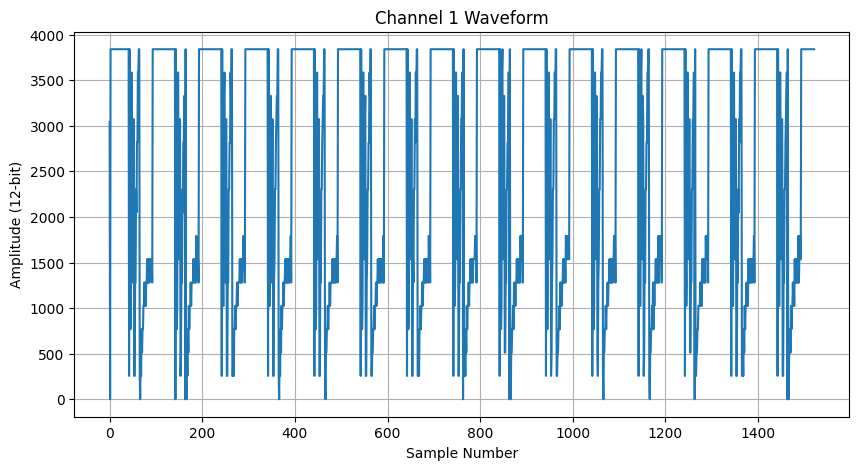

In [130]:
# Set the channel to be active (if needed)
instrument.write(":CH1:DISP ON")  # Turn on Channel 1 display

# Allow time for the instrument to configure
time.sleep(0.1)

instrument.write(":DATA:WAVE:SCREen:HEAD?")  # Send command to request header
raw_header_info = instrument.read_raw()  # Read the raw response

# Allow time for the instrument to configure
time.sleep(0.1)

# Try decoding the raw header info
try:
    header_info = raw_header_info.decode('utf-8')  # Attempt to decode using UTF-8
except UnicodeDecodeError:
    header_info = raw_header_info.decode('latin-1')  # Fallback to Latin-1 if UTF-8 fails

print("Header Info:", header_info)

# Step 2: Fetch the waveform data for Channel 1
instrument.write(":DATA:WAVE:SCREen:CH1?")  # Send command to request waveform data

# Read the binary data
raw_data = instrument.read_raw()  # Read the raw binary data

# Step 3: Convert the raw data from little-endian format
data_points = np.frombuffer(raw_data, dtype=np.uint16)  # Read as 16-bit unsigned integers

# Step 4: Convert to 12-bit values (mask the upper 4 bits)
processed_data = data_points & 0x0FFF  # Mask to get only the lower 12 bits

# Step 5: Plot the data
plt.figure(figsize=(10, 5))
plt.plot(processed_data)
plt.title('Channel 1 Waveform')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (12-bit)')
plt.grid()
plt.show()



In [5]:
# Close the connection
instrument.close()